In [398]:
%load_ext autoreload
%autoreload 2

import sklearn
import scipy
import utils
import meta_utils
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


from matplotlib.patches import Ellipse
import matplotlib.patches 
import matplotlib.path as mpltPath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


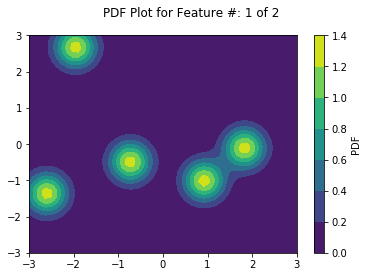

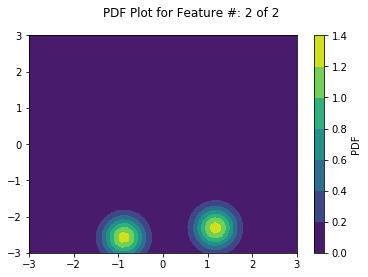

In [364]:
# Testing for generating a gridded space with probabilistic features
cov_mats = (np.array([[ 0.1 , 0], [0,  0.15]]),np.array([[ 0.1 , 0], [0,  0.15]]))
features = (5,2)
(X, Y, Z_list) = meta_utils.gen_gridded_space_PDF(features,cov_mats)

for k in range(len(Z_list)):
    plt.figure()
    testPlot = plt.contourf(X, Y, Z_list[k])
    cbar = plt.colorbar(testPlot )
    cbar.ax.set_ylabel('PDF')
    titleStr = 'PDF Plot for Feature #: ' + str(k + 1) + ' of ' + str(len(Z_list))
    plt.suptitle(titleStr)

plt.figure()


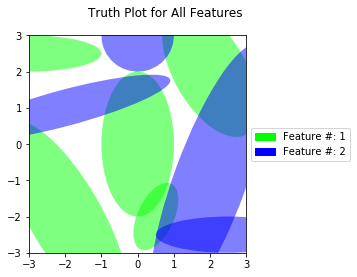

In [392]:
# Testing for generated space with deterministic features.
# the deterministic features are made up from ellipses and are continous
feature_scale = 2
feature_colors = [(0,1,0), (0,0,1)]
'''feature_colors = [(1,0,0), (0,1,0), (0,0,1)]
# plotting 3 features + no features results in a weird image (hard to cleanly plot more than 3 different things by color)
feature_dict = {1:(feature_colors[0], (
    Ellipse((0,0),1*feature_scale,2*feature_scale,0),
    Ellipse((2,2),1*feature_scale,2*feature_scale,30),
    Ellipse((0.5,-2),1*feature_scale,0.5*feature_scale,245))), 
                   2: (feature_colors[1], (
                       Ellipse((-2,1),3*feature_scale,0.5*feature_scale,15),
                       Ellipse((0,3),1*feature_scale,1*feature_scale,15),
                       Ellipse((2,-1),4*feature_scale,1*feature_scale,70),)),
                   3: (feature_colors[2], (
                       Ellipse((2.5,-2.5),2*feature_scale,0.5*feature_scale,0),
                       Ellipse((-2,-2),1*feature_scale,3*feature_scale,30),
                       Ellipse((-3,2.5),2*feature_scale,0.5*feature_scale,0)))}  '''  

feature_dict = {1:(feature_colors[0], (
    Ellipse((0,0),1*feature_scale,2*feature_scale,0),
    Ellipse((2,2),1*feature_scale,2*feature_scale,30),
    Ellipse((0.5,-2),1*feature_scale,0.5*feature_scale,245),
    Ellipse((-2,-2),1*feature_scale,3*feature_scale,30),
    Ellipse((-3,2.5),2*feature_scale,0.5*feature_scale,0))), 
                   2: (feature_colors[1], (
                       Ellipse((-2,1),3*feature_scale,0.5*feature_scale,15),
                       Ellipse((0,3),1*feature_scale,1*feature_scale,15),
                       Ellipse((2,-1),4*feature_scale,1*feature_scale,70),
                       Ellipse((2.5,-2.5),2*feature_scale,0.5*feature_scale,0)))}
   

meta_utils.plot_truth_features(feature_dict)



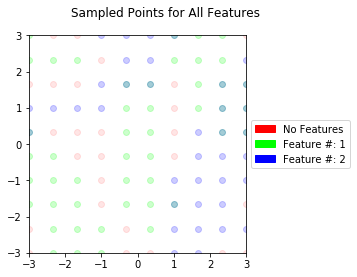

In [395]:
# Test gridded representation of the features (low res, initial sample)
N_test = 10
(X,Y,Z) = meta_utils.gen_gridded_space_DET(feature_dict, N=N_test)

meta_utils.plot_sampled_features(X,Y,Z,feature_dict, N=N_test)

(X_init, y_init) = meta_utils.parse_map_for_GP(X,Y,Z,parseNoFeatures = True)

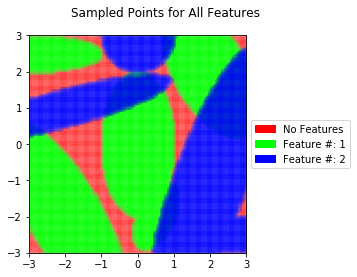

In [396]:
# Test gridded representation of the features (highest res possible)
N_test = 100
(X,Y,Z) = meta_utils.gen_gridded_space_DET(feature_dict, N=N_test)

meta_utils.plot_sampled_features(X,Y,Z,feature_dict, N=100)

(X_highRes, y_highRes) = meta_utils.parse_map_for_GP(X,Y,Z,parseNoFeatures = True)

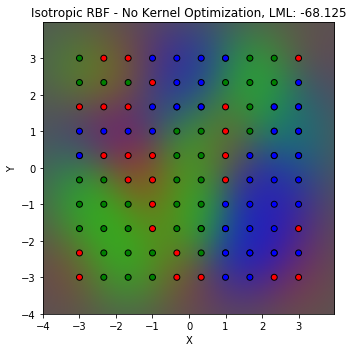

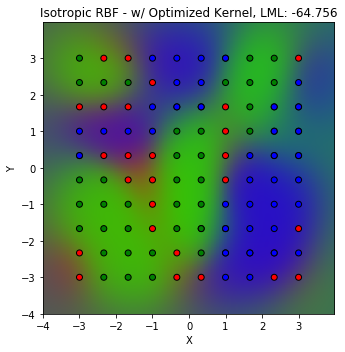

In [399]:
# Need to parse point data into X and y
# indicies of this array correspond to the indicies of y_forGP

h = .02  # step size in the mesh
kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic_noOpt = GaussianProcessClassifier(kernel=kernel,optimizer = None).fit(X_init, y_init)
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X_init, y_init)

x_min, x_max = x_lim[0] - 1, x_lim[1] + 1
y_min, y_max = y_lim[0] - 1, y_lim[1] + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
titles = ["Isotropic RBF - No Kernel Optimization", "Isotropic RBF - w/ Optimized Kernel"]
for i, clf in enumerate((gpc_rbf_isotropic_noOpt, gpc_rbf_isotropic )):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    utils.plot_GP_and_data(clf,X_init,y_init,title = titles[i])

# THIS NOTEBOOK IS INTENDED FOR INSTRUCTOR / ADAPTIVE SAMPLING TEAM USE ONLY
## This provides an example of a completed notebook

START ACTUAL NOTEBOOK BELOW
***
***
***


# Optimal Design of Experiment for Adaptive Sampling
## A look at online information gathering

For this PSet we'll be walking you through the core of adaptive sampling theory -- namely we'll be having you react to observations made in an unknown environment in order to best address a goal of your robot. 

## Preliminaries: Modeling as a GP and Information Theory

First, we'll be asking you to review a little bit about Gaussian Processes (GPs) in order to understand how we'll be asking you to model your probabilistic belief in the world as you navigate and take samples. We will also present a primer on information-theoretic measures to set you up for starting to formulate the relevant functions necessary to motivate the adaptive sampling problem.

Let's start with your world representation. In many adaptive sampling tasks, the robot has little to no information about the environment of interest. As samples are collected, the robot should be able to start modeling the environment probabilistically in order to inform the next trajectories. As we learned in a previous lecture, GPs are a particualrly compelling technique for modeling distributions of a variable of interest when we are not interested or are not able to define specific parameters. We're asking you to keep a map of your belief through a GP representation for this exercise. 

We have provided a helpful library for creating, updating, and plotting your GP belief map. Let's get familiar with it.

Now it is your turn. Please complete the function which takes as input a GP instance and a sample of data, and returns an updated GP instance.

In [405]:
def update_belief(GP, new_sample, X_train, y_train):
    """
    input: 
    GP -- a GP object
    sample -- data with information that can be used to update the GP object, in the form of a tuple:
        -- first element is an np.array with all the new X values (x,y grid points)
        -- second element is an np.array with allt he new y values (classes related by index to each x,y grid point)
    
    output: updated GP object
    """
    # this is how you should be able to do it...
    # Pull out the Kernel parameters!
    
    # Update the Kernel parameters with the data from each new sample
    
    # return updated GP
    
    # this is the quick way to do it (to test the rest of the PSET)
    X_new = X_train.copy()
    y_new = y_train.copy()

    for new_ind in range(len(new_sample[0])):
        X_new = np.append(X_new,[new_sample[0][new_ind]],axis=0)
        y_new = np.append(y_new,[new_sample[1][new_ind]],axis=0)

    updated_GP = GaussianProcessClassifier(kernel=kernel).fit(X_new, y_new)
    
    return updated_GP

Let's check that it works with a simple fitting problem:

In [413]:
#instantiate a GP instance
original_GP = GaussianProcessClassifier(kernel=kernel).fit(X_init, y_init)

#have a list of data
num_samples = 20
sample_inds = np.random.randint(0,X_highRes.shape[0],size=num_samples)
new_sample = (X_highRes[sample_inds,:],y_highRes[sample_inds])

updated_GP = update_belief(original_GP, new_sample, X_init, y_init)

#iterate through the list of data and use the update_belief function (not done in initial version)

#check that it matches the expectation (need to discuss test development)

[ 4012  9022  8463   754  3514  3749  9083  1567  5306  4106   912  1565
  5194 10505 10326  1495 10406  2365  4590  6161]


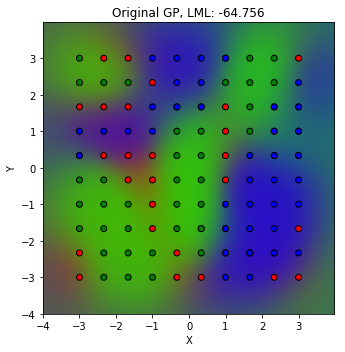

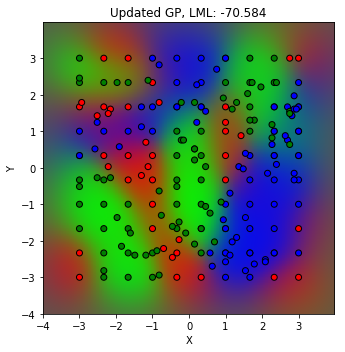

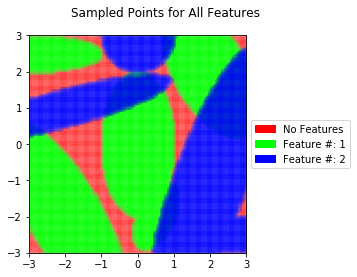

In [414]:
# let's plot the original and updated GP
utils.plot_GP_and_data(original_GP,X_train,y_train,title = "Original GP")
utils.plot_GP_and_data(updated_GP,X_new,y_new,title = "Updated GP")

# below comparison to truth is for testing purposes only - REMOVE DURING ACTUAL PSET
meta_utils.plot_sampled_features(X,Y,Z,feature_dict, N=100)

Now that you're ready to start collecting belief, let's introduce you to a few ways of defining "information"....[INSERT DISCUSSION ABOUT INFORMATION HERE].

[HAVE STUDENTS IMPLEMENT A FEW MEASURES OF "INFORMATION" ON A SET OF DATA AND COMPARE THOSE MEASURES].

In [5]:
###### TODO: (Takaya focus)
#walk through of implementing information measures (provide a set of data to look at)
#help them visualize/compare these measures 

Great! You're now ready to start formulating the goal for your vehicle and compelling it to start adaptive sampling.

## Expressing Reward and Cost

Central to the adaptive sampling problem is expressing an objective (generally maximizing information gain or minimizing uncertainty) and formulating an appropriate reward and cost function for the vehicle. These functions are ultimately applied to all possible actions in order to choose the "best" action at that time.

For this PSet, we would like you to work with this objective:

$$ arg \max\limits_{r \in S} I(r) \quad \textrm{s.t.} \quad C(r) \leq B $$

That is, from all possible actions, choose the action which maximizes information along that action; subject to a budgetary constraint applied to the cost of the action.

### What's Rewarding in Adaptive Sampling?

Depending on the specific application of this adaptive sampling platform, there may be several different ways of formulating this reward. Let's look at three of them:

**Exploitative -- High Values** -- Sometimes all we care about is collecting samples that are "interesting" because they have a high 'science' benefit. (One might think about the case of sampling in the ocean, and only focusing on areas with dissolved CO2 or methane higher than some baseline threshold). This is known as an exploitative reward. Write a function which takes in a series of sample measurements and selects the most exploitative sample.

In [441]:
# I think we may need another function that takes our current GP and queries a location to then return the mean and variance of the sample reward

# Instructions (assume features EXPLOIT reward are uncorrelated):
# No Feature: Has a mean exploitative reward of 0, with a standard deviation of 1 (can't go below zero)
# Feature #1: Has a mean exploitative reward of 6 with standard deviation of 2 (can't go below zero)
# Feature #2: Has a mean exploitative reward of 5 with standard deviation of 3 (can't go below zero)

def get_location_stats(GP, point, feature_stats):
    """
    INPUT:
    GP: gaussian process representing the classification of features on the grid
    point: (x1,x2) point on the grid (note that sklearn needs it to be in the following format point = np.array([x1,x2]).reshape(1,-1)) 
    feature_stats: is a list that has a tuple for each feature (mean_feature, var_feature)
    
    OUTPUT: a tuple with (mean, variance) of the sample according to the current GP and instructions above
    """
    point = point.reshape(1,-1)
    likelihoods = GP.predict_proba(point)[0]
    mean = 0
    var = 0
    
    for k in range(len(feature_stats)):
        mean += feature_stats[k][0]*likelihoods[k]
        # I MAY NOT BE ADDING VARIANCE CORRECTLY :()
        var += feature_stats[k][1]*likelihoods[k]

    return (mean,var)

num_points= 20
points = 6 * np.random.random((num_samples,2)) - 3

feature_stats = [(0,1),(6,4),(5,9)]
def get_exploitative_reward(GP, points, feature_stats):
    """
    input:
    samples -- a list of sample tuples
        --element 1: (x,y) location on a grid
        --element 2: tuple with (mean, variance) values
    
    output:
    return the location of the most exploitative sample
    """
    samples = []
    for k in range(points.shape[0]):
        samples.append((points[k,:],get_location_stats(GP, points[k,:], feature_stats)))

    best_mean = 0
    for sample in samples:
        if sample[1][0] > best_mean:
            best_mean = sample[1][0]
            best_sample_loc = sample[0]
            
    return best_sample_loc

get_exploitative_reward(updated_GP,points, feature_stats)

array([-0.00479778, -1.26042024])

In [7]:
##### TODO (completing the plotting utility will be helpful for the lecture slides!):
# WRITE PLOTTING UTILITY TO TAKE IN CURRENT GP, PLOT IMAGE, THEN TAKE IN NEW SAMPLES AND PLOT 'BEST SAMPLE' with a star
# WRITE TESTS
# Test 3 sample sets with (1, 5, and 20 samples each), to make sure they are selecting the "best" one

**Explorative -- Coverage is Key** -- Now we consider the case in which we only care about collecting samples which we have low certainty on. Imagine a scenario in which all we want is a good survey of a large area -- this reward should help to optimize a path which "sees" a lot of this area.

In [442]:
# There is where we have to sync up with the information gain metric above

# I will implement a naive metric that just finds the lowest MLE from the samples (showing we have the least feature certainty)
num_points= 20
points = 6 * np.random.random((num_samples,2)) - 3

def get_explorative_reward(GP, points):
    """
    input:
    samples -- a list of samples (includes location and mean/variance of the sample)
    
    output:
    returns the location of the most explorative sample
    """
    min_MLE = 1
    for k in range(points.shape[0]):
        point = points[k].reshape(1,-1)
        likelihoods = GP.predict_proba(point)[0]
        if max(likelihoods) < min_MLE:
            min_MLE = max(likelihoods)
            best_sample_loc = point

    return best_sample_loc

get_explorative_reward(updated_GP, points)

array([[0.8854994 , 2.10642574]])

In [9]:
##### TODO (completing the plotting utility will be helpful for the lecture slides!):
# WRITE PLOTTING UTILITY TO TAKE IN CURRENT GP, PLOT IMAGE, THEN TAKE IN NEW SAMPLES AND PLOT 'BEST SAMPLE' with a star
# WRITE TESTS
# Test 3 sample sets with (1, 5, and 20 samples each), to make sure they are selecting the "best" one

**Trading off** -- Sometimes we actually care about both exploring in high value areas and seeing a lot of the world. This is the "explore-exploit" tradeoff, and this is well discussed in the literature. Often the elements of explore are weighted by some parameter $\beta$. Please write a function that takes in a set of samples and some $\beta$ and returns the best trade-off value.

In [10]:
def get_explore_exploit_reward(samples, beta):
    """
    input:
    samples -- a list of samples (includes location and mean/variance of the sample)
    beta -- a parameter which weights the importance of exploring
    
    output:
    returns the location of the best trade-off sample
    """
    #TODO your code here!
    raise NotImplementedError("Not yet implemented")
    return

In [11]:
##### TODO (completing the plotting utility will be helpful for the lecture slides!):
# WRITE PLOTTING UTILITY TO TAKE IN CURRENT GP, PLOT IMAGE, THEN TAKE IN NEW SAMPLES AND PLOT 'BEST SAMPLE' with a star
# WRITE TESTS
# Test 3 sample sets with (1, 5, and 20 samples each), to make sure they are selecting the "best" one

### How costly is sampling?

Finally, we want to also be able to quantify how costly taking a certain sample is. For the purposes of this PSet, let's define cost as "cost to go" -- that is, the euclidean distance between the pose of the vehicle and the location of the sample. Please complete the cost function below with this in mind.

In [12]:
def cost(pose, sample):
    """
    input:
    pose -- location of the vehicle
    sample -- a sample that needs to be assessed; includes location information
    
    output:
    returns the cost-to-go
    """
    #TODO your code here!
    raise NotImplementedError("Not yet implemented")
    return

In [13]:
##### TODO
#test their function

## Getting Around: Navigating based on Sample Utility

Now that we have formulated our reward and cost functions, let's think about how we'll apply them to getting around a world. We've endowed your robot with the ability to go forward, back, right, and left. These are "action primitives" in this world, and you can think of these as $S$ in your objective formulation. In order to select the best action at each time step, you will need to apply your reward and cost functions to each of these actions to assess two things: that the action has the best reward, and that the action is "within budget." 

Complete the function below that will take in your current location, your action primitives, and your GP in order to pick the best primitive.

In [14]:
# TODO: Consider also adding a "horizon" parameter to allow them to plan X steps ahead (Start with 1, max of 5).

def pick_primitive(pose, belief, budget, primitive_set, reward_function='exploit'):
    """
    input:
    pose -- robot's current position in the world
    belief -- GP instance
    budget -- the budget that is left for sampling
    primitive_set -- the actions which can be taken (represented as step-sizes in the world)
    reward_function -- keyword for which reward function to be used
    """
    # TODO your code here!
    raise NotImplementedError("Not yet implemented")
    return

In [15]:
##### TODO
#test their function

## Putting it All Together: Exploring Europa

You've just joined the engineering team responsible for determining how one of the rovers on the next trip to Europa should be collecting samples. This is a complicated task -- we don't have a great sense of the type of environment that the rover will be landing in, though we know that we are generally interested in the density of carbon in ice samples taken from the surface. As sampling is the only way we can learn about this icy sphere, it is critical that the samples collected are somewhat representative of the area that the rover has landed in. As the rover has a number of other missions it needs to conduct, your team has been given a budget of how much the vehicle can travel before the next mission starts. 

Finish your work so far by allowing the utility assessment to operate over multiple timesteps until the budget is depleted. Return the total reward you've collected, the series of actions you've taken, and the final belief map.

In [17]:
def explore_europa(budget, primitive_set, reward_type="exploit", beta=0):
    """
    input:
    budget -- the total travel budget allowed for your mission
    primitive_set -- the known ways the robot can move at each time step
    reward_type -- determine which reward function to use
    beta -- relevant to if the exploit-explore reward is used
    
    output:
    total_reward -- how much reward was accumulated during the search
    actions_taken -- list of all of the decisions
    final_map -- final GP instance
    """
    # TODO your code here!
    raise NotImplementedError("Not yet implemented")
    return

In [18]:
###### TODO: start with horizon of 1
# Run through beta from 0 to 0.5 to 1 for a low resolution starting map (only 5-10 grid points)

# Run through beta from 0 to 0.5 to 1 for a high resolution starting map (up to 50 grid points to start)

# discuss differences between the two different starting resolution levels.  Was it what you expected? 
# What real world operational considerations do these scenarios illustrate?

# Pick a Beta value and set a horizon of 5 steps on low resolution map, then repeat for high resolution and answer similar questions


## Limitations and Open Areas -- How Much is Enough?

What did you notice when you adjusted the reward function you used? Or beta? What are the limitations of using a pre-specified budget value?

*Your Answer Here, Please*

## Conclusions

You've now successfully implemented the core pipeline for adaptive sampling. There is a LOT of literature out there which explores this problem in a number of other contexts: active SLAM, active learning, sensor selection, informative path planning, the multi-armed bandit problem, etc. In nearly any online type setting in robotics, being able to adapt to one's environment is critical to success of the platform.